In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import matplotlib.pyplot as plt
import numpy as np

from multiprocessing import freeze_support

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

In [2]:
## First we load and normalize CIFAR10 using torch vision:

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

# development set - includes training and validation sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0) 

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Trying to show some of the training images to test it out
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
## Define a Convolutional Neural Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
## Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
## Train the network    
train_losses = [] # track losses for plotting
train_accuracies = []
correct_train = 0
total_train = 0
test_losses = []
test_accuracies = []
correct_test = 0
total_test = 0

for epoch in range(13):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    # calculate training losses
    for i, data in enumerate(trainloader, 0): # note trainloader has 12500 batches
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print loss statistics
        running_loss += loss.item()
    print(f'[{epoch + 1}] training loss: {running_loss / len(trainloader):.3f}')
    train_losses.append(running_loss / len(trainloader)) # check
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] training loss: {running_loss / 2000:.3f}')
#             train_losses.append(running_loss / 2000) # store training losses to plot later
#             running_loss = 0.0
            
            
    net.eval()
    with torch.no_grad():
        # calculate test losses
        running_loss = 0.0
#         i = 0
        correct_test = 0
        total_test = 0
        for data in testloader:
            inputs, labels = data

            # forward pass
            # calculate outputs by running images through the network
            outputs = net(inputs)

            # calculate test losses
            loss = criterion(outputs, labels)
            running_loss += loss.item()        
#             if i % 400 == 399:    # print every 100 mini-batches
#                 print(f'[{epoch + 1}, {i + 1:5d}] test loss: {running_loss / 400:.3f}')
#                 test_losses.append(running_loss / 400) # store losses to plot later
#                 running_loss = 0.0
#             i += 1

            # calculate test accuaracies
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
        test_accuracy = 100 * correct_test / total_test
        print(f'[{epoch + 1}] test accuracy: {test_accuracy}') # check
        test_accuracies.append(test_accuracy)
        
        print(f'[{epoch + 1}] test loss: {running_loss / len(testloader):.3f}') # check
        test_losses.append(running_loss / len(testloader)) # store losses to plot later
        
        
        # calculate training accuracies
        correct_train = 0
        total_train = 0
        i = 0
        for data in trainloader: # note trainloader has 12500 batches
            inputs, labels = data
            outputs = net(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            i += 1
        train_accuracy = 100 * correct_train / total_train
        print(f'[{epoch + 1}] train accuracy: {train_accuracy}') # check
        train_accuracies.append(train_accuracy)
        
print('Finished Training')

# save our trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

[1] training loss: 1.733
[1] test accuracy: 48.02
[1] test loss: 1.422
[1] train accuracy: 48.16
[2] training loss: 1.345
[2] test accuracy: 56.45
[2] test loss: 1.246
[2] train accuracy: 57.484
[3] training loss: 1.208
[3] test accuracy: 57.07
[3] test loss: 1.209
[3] train accuracy: 59.89
[4] training loss: 1.118
[4] test accuracy: 56.88
[4] test loss: 1.269
[4] train accuracy: 60.282
[5] training loss: 1.052
[5] test accuracy: 59.61
[5] test loss: 1.141
[5] train accuracy: 65.172
[6] training loss: 0.992
[6] test accuracy: 61.92
[6] test loss: 1.095
[6] train accuracy: 69.042
[7] training loss: 0.947
[7] test accuracy: 62.72
[7] test loss: 1.075
[7] train accuracy: 70.788
[8] training loss: 0.906
[8] test accuracy: 61.85
[8] test loss: 1.134
[8] train accuracy: 71.1
[9] training loss: 0.874
[9] test accuracy: 62.41
[9] test loss: 1.109
[9] train accuracy: 72.818
[10] training loss: 0.841
[10] test accuracy: 60.97
[10] test loss: 1.209
[10] train accuracy: 71.466
[11] training loss: 

In [7]:
## Now we will observe how the network performs on the whole dataset
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(correct)
print(total)
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

6113
10000
Accuracy of the network on the 10000 test images: 61 %


In [8]:
## Observe how individual classes performed

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 71.5 %
Accuracy for class: car   is 82.8 %
Accuracy for class: bird  is 49.8 %
Accuracy for class: cat   is 32.7 %
Accuracy for class: deer  is 50.1 %
Accuracy for class: dog   is 58.2 %
Accuracy for class: frog  is 77.2 %
Accuracy for class: horse is 67.1 %
Accuracy for class: ship  is 51.1 %
Accuracy for class: truck is 70.8 %


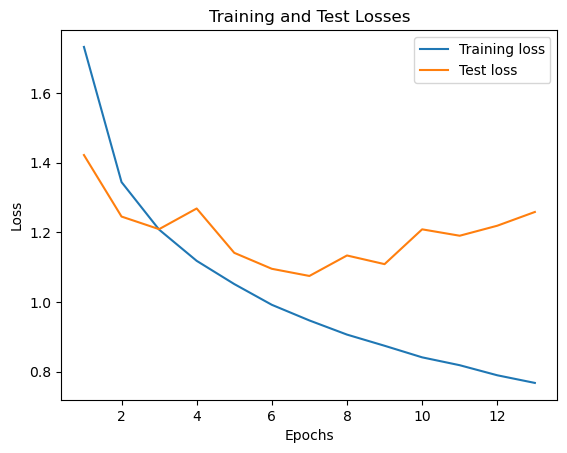

In [9]:
## Plot training and test losses over epochs 
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, test_losses, label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

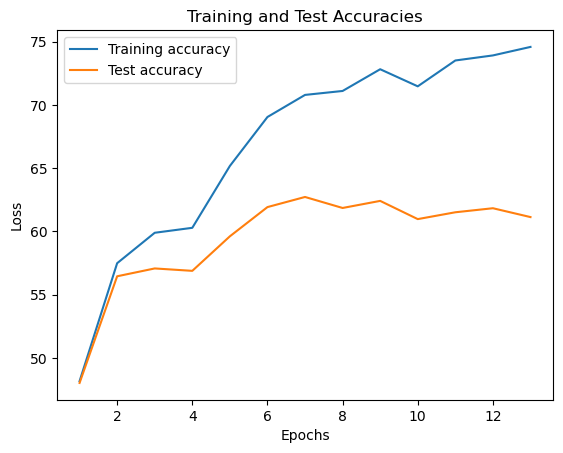

In [10]:
## Plot training and test accuracies over epochs 
epochs = range(1, len(train_accuracies) + 1)
plt.plot(epochs, train_accuracies, label='Training accuracy')
plt.plot(epochs, test_accuracies, label='Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Accuracies')
plt.legend()
plt.show()